In [1]:
from __future__ import annotations

from dataclasses import dataclass
from typing import *
from collections import defaultdict
import graphlib
import statistics

from matplotlib import pyplot as plt
import timeit
import igraph
import functools

import graphlib2


In [2]:
T = TypeVar("T", bound=Hashable)

Graph = Dict[T, List[T]]


In [3]:
@functools.cache
def get_linear_graph(n: int) -> Graph[int]:
    g = igraph.Graph.Tree(n, 1)
    res: Dict[int, List[int]] = defaultdict(list)
    for source, dest in g.get_edgelist():
        res[source].append(dest)
    return res

@functools.cache
def get_branched_graph(n: int) -> Graph[int]:
    g = igraph.Graph.Tree_Game(n, directed=True)
    res: Dict[int, List[int]] = defaultdict(list)
    for source, dest in g.get_edgelist():
        res[source].append(dest)
    return res

In [4]:
def run(
    t: Union[graphlib2.TopologicalSorter[T], graphlib.TopologicalSorter[T]],
    graph: Graph[T],
) -> None:
    to_remove = t.get_ready()
    while t.is_active():
        t.done(*to_remove)
        to_remove = t.get_ready()


def setup_rust(graph: Graph[T]) -> graphlib2.TopologicalSorter[T]:
    t: graphlib2.TopologicalSorter[T] = graphlib2.TopologicalSorter(graph)
    t.prepare()
    return t


def setup_python(graph: Graph[T]) -> graphlib.TopologicalSorter[T]:
    t: graphlib.TopologicalSorter[T] = graphlib.TopologicalSorter(graph)
    t.prepare()
    return t


def copy_rust(ts: graphlib2.TopologicalSorter[T], graph: Graph[T]) -> None:
    ts.copy()


def copy_python(ts: graphlib.TopologicalSorter[T], graph: Graph[T]) -> None:
    setup_python(graph)


In [5]:
@dataclass
class Target(Generic[T]):
    rust: Callable[[Union[graphlib2.TopologicalSorter[T], graphlib.TopologicalSorter[T]], Graph[T]], None]
    python: Callable[[Union[graphlib2.TopologicalSorter[T], graphlib.TopologicalSorter[T]], Graph[T]], None]


def plot(
    upper: int,
    samples: int,
    graph_factory: Callable[[int], Graph[T]],
    target: Target[T],
    lower: int = 0,
    loops: int = 10,
) -> None:
    samples = min(samples, upper-lower)
    x = [round(lower + x*(upper-lower)/samples) for x in range(samples)]
    y_python: List[float] = []
    y_rust: List[float] = []

    glbls = {
        "graph_factory": graph_factory,
        "target_rust": target.rust,
        "target_python": target.python,
    }

    for n in x:
        setup = f"graph = graph_factory({n}); ts = ts_factory(graph)"
        # Time Python and get the # of loops and match that
        timerpy = timeit.Timer(stmt="target_python(ts, graph)", setup=setup, globals={**glbls, "ts_factory": setup_python})
        pytime = timerpy.repeat(loops, number=1)
        y_python.append(statistics.median(pytime))
        timerust = timeit.Timer(stmt="target_rust(ts, graph)", setup=setup, globals={**glbls, "ts_factory": setup_rust})
        rustime = timerust.repeat(loops, number=1)
        y_rust.append(statistics.median(rustime))
    plt.plot(x, y_python, label="python")
    plt.plot(x, y_rust, label="rust")
    plt.legend(loc="upper left")
    plt.xlabel("V (number of vertices)")
    plt.ylabel("Execution time (s)")

## Benchmarks against graph size

For a linear graph (A -> B -> C -> ... n)

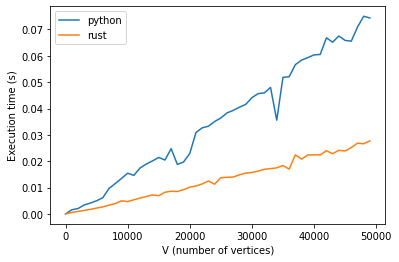

In [6]:
plot(upper=50_000, samples=50, loops=7, graph_factory=get_linear_graph, target=Target(run, run))

For a randomized branched graph (A -> B, A -> C, A -> D, ... A -> n, ... B -> C, C -> D, ...)

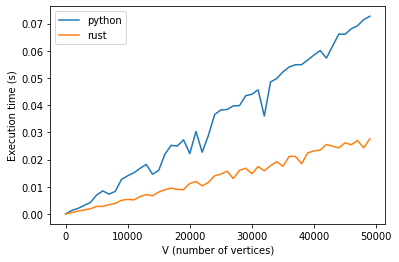

In [7]:
plot(upper=50_000, samples=50, loops=7, graph_factory=get_linear_graph, target=Target(run, run))

Zoom in on small graphs

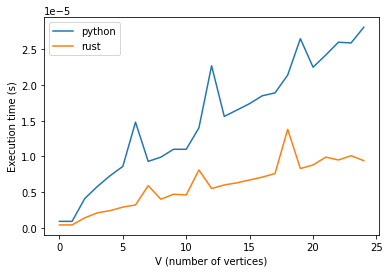

In [8]:
plot(upper=25, samples=50, loops=15, graph_factory=get_linear_graph, target=Target(run, run))

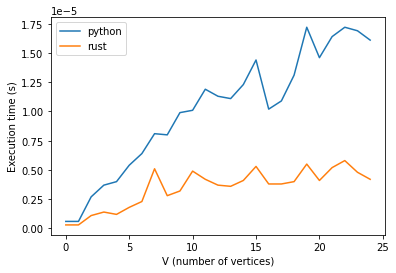

In [9]:
plot(upper=25, samples=50, loops=15, graph_factory=get_branched_graph, target=Target(run, run))

Measure copying a `ToplogicalSorter` instance.
The standard library does not have a `copy()` method, so we just re-create the `ToplogicalSorter`, which is inefficient but is the only option available.

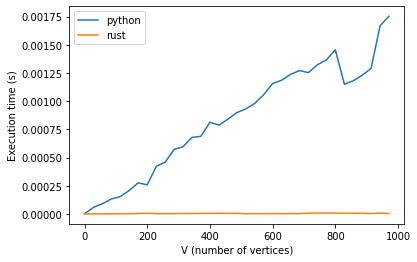

In [10]:
target: Target[T] = Target(rust=copy_rust, python=copy_python)
plot(upper=1_000, samples=35, loops=15, graph_factory=get_branched_graph, target=target)

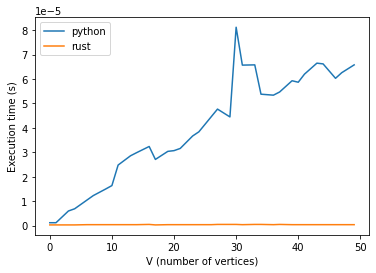

In [11]:
plot(upper=50, samples=35, loops=15, graph_factory=get_branched_graph, target=target)

Time copying a `graphlib2.ToplogicalSorter` so it can be compared against itself

In [12]:
%%timeit ts = setup_rust(get_branched_graph(100))
ts.copy()

269 ns ± 6.36 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
